#Mount Google Drive and unzip data

In [75]:
#mounting google drive (data are placed in root in zip file)

from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [76]:
!unzip -q "/content/drive/MyDrive/places_64x64_new.zip"

# Import:


*   own developed modules from Google Drive
*   standard libs and 3rd party libs


In [77]:
import sys
sys.path.append('/content/drive/MyDrive')

from dataread import DataRead
from network_structure import buildGenerator, buildDiscriminator

In [78]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Activation, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, Lambda
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, Adadelta
from keras import losses, activations
from keras.utils import to_categorical
import keras.backend as K
from keras.utils.vis_utils import plot_model
import scipy
import tensorflow as tf
from IPython.display import clear_output

import matplotlib.pyplot as plt

import time
import numpy as np

# Define custom loss functions for the network

In [79]:
#mse loss for the generator in phase III
def generatorMSELossInJoint(y_true, y_pred):
    #print("weightedMSELoss --- y_true.shape=",y_true.shape, "y_pred.shape=",y_pred.shape)
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [80]:
#adversarial loss for the generator in phase III
def generatorAdversarialLoss(y_true, y_pred):
        #print("generatorAdversarialLoss --- y_true.shape=", y_true.shape, "y_pred.shape=", y_pred.shape)
        real = y_pred[:, 0]
        fake = y_pred[:, 1]
        loss_real = K.mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real, labels=tf.zeros_like(real)))
        loss_fake = K.mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake, labels=tf.ones_like(fake)))
        loss = loss_real + loss_fake
        return loss

In [81]:
#adversarial loss for the discriminator in phase II
def discriminatorAdversarialLoss(y_true, y_pred):
        real = y_pred[:, 0]
        fake = y_pred[:, 1]
        loss_real = K.mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real, labels=tf.ones_like(real)))
        loss_fake = K.mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake, labels=tf.zeros_like(fake)))
        loss = loss_real + loss_fake
        # loss = util.tfprint(loss, "discriminator_loss")
        return loss

# Define network container (and builder) class

In [96]:
class GANScape():
    def __init__(self, batchSize=32, inputImgShape=(64,64,3), localDiscInputShape=(28,28,3)):
        #self.imgHeight = 64
        #self.imgWidth = 64
        #self.channels = 4
        self.batchSize = batchSize
        self.inputImgShape = inputImgShape
        self.localDiscInputShape = localDiscInputShape
        self.weightForAdversarialInJointLoss = 0.1
        
        optimizer = Adadelta()
        

        
    def compileModel(self, model, losses, optimizer, lossWeights=None):
        if lossWeights is None:
            model.compile(loss = losses,optimizer = optimizer)
        else:
            model.compile(loss = losses,optimizer = optimizer, loss_weights=lossWeights)
        return model
    



    #operation for lamda layer between [generator-output] -> [local-discriminator-input]
    def cropLocalDiscInputFromImg(self, realImgs, fakeImgs, maskParams):
        realImgs = tf.split(realImgs, self.batchSize)
        fakeImgs = tf.split(fakeImgs, self.batchSize)
        maskParams = tf.split(maskParams, self.batchSize)
        realLocalInputs = []
        fakeLocalInputs = []
        for real, fake, maskParam in zip(realImgs, fakeImgs, maskParams):
            fake = K.squeeze(fake, 0)
            real = K.squeeze(real, 0)
            maskParam = K.cast(K.squeeze(maskParam, 0), tf.int32)

            top = maskParam[0]
            left = maskParam[1]
            h = maskParam[2] - top + 1
            w = maskParam[3] - left + 1

            realImgLocalInput = tf.image.crop_to_bounding_box(
                real, top, left, h, w)
            realLocalInputs.append(realImgLocalInput)
            
            fakeImgLocalInput = tf.image.crop_to_bounding_box(
                fake, top, left, h, w)
            fakeLocalInputs.append(fakeImgLocalInput)


        realLocalInputs = K.stack(realLocalInputs)
        fakeLocalInputs = K.stack(fakeLocalInputs)

        return [realLocalInputs,  fakeLocalInputs]
        
    
    
    def compileAll(self):
        #define inputs
        genInputShape = (self.inputImgShape[0], self.inputImgShape[1], self.inputImgShape[2])
        inputImgGen = Input(genInputShape, name='input_image_layer_for_generator')
        
        maskParamsInputLocalDisc = Input(shape=4, name='input_mask_params_for_local_disc')
        realInputLocalDisc = Input(shape=self.localDiscInputShape, name='input_real_mask_img_for_local_disc')
        
        realInputGlobalDisc = Input(shape=self.inputImgShape, name='input_real_img_for_global_disc')
        
        #build generator and discriminator
        self.generator = buildGenerator(inputImgGen)
        self.discriminator = buildDiscriminator(realInputGlobalDisc, realInputLocalDisc)
        
        fakeInputGlobalDisc = self.generator.layers[-1].output
    
        # local discriminator get the output of generator through a Lamda layer that cuts the inpainted part of the image
        realInputLocalDisc, fakeInputLocalDisc = Lambda(lambda x: self.cropLocalDiscInputFromImg(*x),name='crop_local_disc_input_from_img')([realInputGlobalDisc, fakeInputGlobalDisc, maskParamsInputLocalDisc])
        realProb =  self.discriminator([realInputGlobalDisc, realInputLocalDisc])
        fakeProb =  self.discriminator([fakeInputGlobalDisc, fakeInputLocalDisc])
        
        #print("prob_real: ", realProb)
        #print("prob_fake: ", fakeProb)
        def _stack(pReal, pFake):
            prob = K.squeeze(K.stack([pReal, pFake], -1), 1)
            #print(prob)
            return prob
        probs = Lambda(lambda x: _stack(*x), name='stack_prob')([realProb, fakeProb])
        # print("prob: ", prob)
        
        outputsForOnlyDisc = [probs]
        lossesForOnlyDisc = [discriminatorAdversarialLoss]
        outputsForOnlyGenJoint = [fakeInputGlobalDisc, probs]
        lossesForOnlyGenJoint = [generatorMSELossInJoint, generatorAdversarialLoss]
        lossWeightForOnlyGenJoint = [1, self.weightForAdversarialInJointLoss]
        
        ########################################################x
        #COMPILE TRAINING MODELS - we will have 3 different compiled variables (but the same network) becasuse we need:
        #   -different losses
        #   -different input-output combinations
        # in the 3 different phases of training
        
        combinedModelTrainOnlyDisc = Model([inputImgGen, maskParamsInputLocalDisc, realInputGlobalDisc], outputsForOnlyDisc)
        combinedModelTrainOnlyGenWithJoint = Model([inputImgGen, maskParamsInputLocalDisc, realInputGlobalDisc], outputsForOnlyGenJoint)
        
        self.modelForTrainOnlyGenWithMSE = self.compileModel(self.generator, 'mean_squared_error', Adadelta())
        self.modelForTrainOnlyDisc = self.compileModel(combinedModelTrainOnlyDisc, lossesForOnlyDisc, Adadelta())
        self.modelForTrainOnlyGenWithJoint = self.compileModel(combinedModelTrainOnlyGenWithJoint, lossesForOnlyGenJoint, Adadelta(), lossWeights=lossWeightForOnlyGenJoint)

    

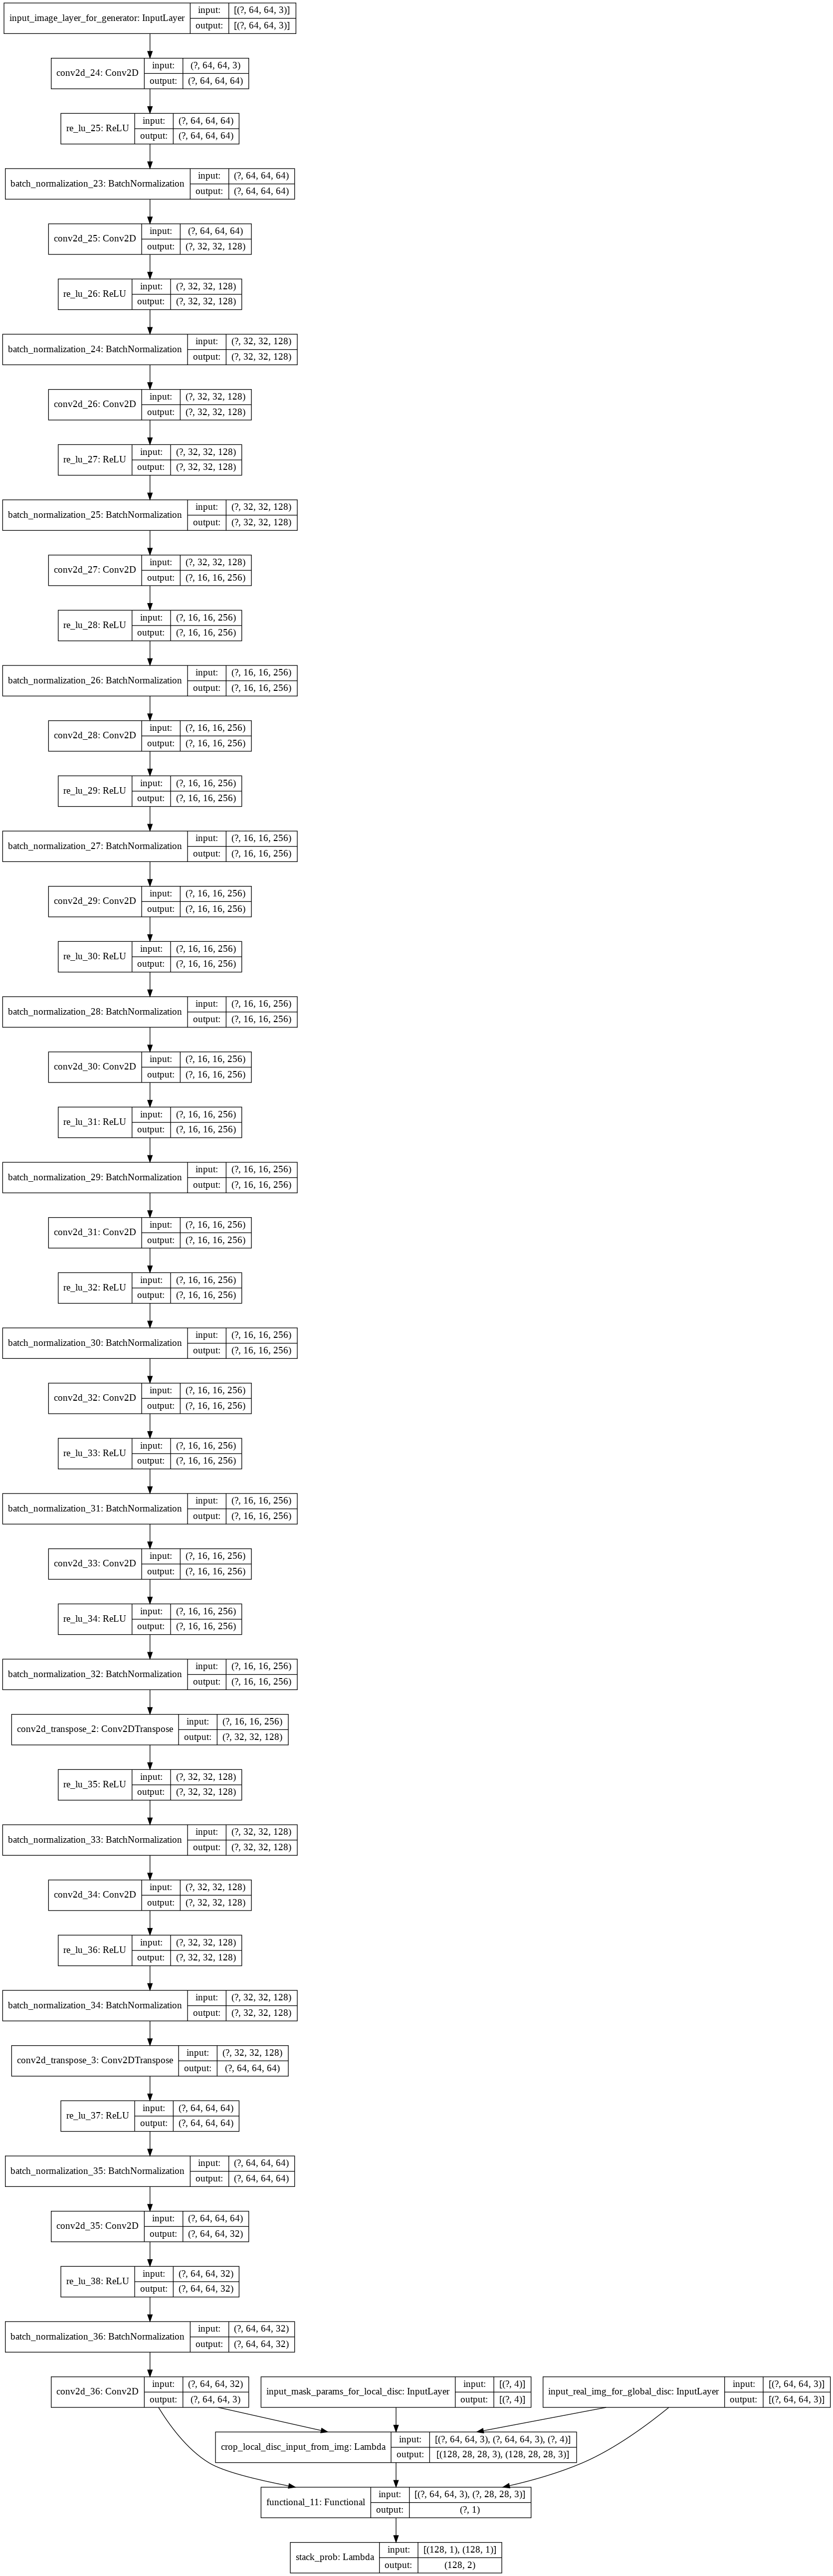

In [97]:
#plot model architecture in different train-cases (all of the 3 different train-phases are represented by a different variable)

plot_model(net.modelForTrainOnlyGenWithMSE, to_file='modelForTrainOnlyGenWithMSE.png', show_shapes=True, show_layer_names=True)
plot_model(net.modelForTrainOnlyDisc, to_file='modelForTrainOnlyDisc.png', show_shapes=True, show_layer_names=True)
plot_model(net.modelForTrainOnlyGenWithJoint, to_file='modelForTrainOnlyGenWithJoint.png', show_shapes=True, show_layer_names=True)


# Define functions:
*   train (training and validiation)
*   test (evaluation) functions



In [105]:
#function for training and validation
#   net: object of tpye GANScape - contains different compiled model variables (with the same network) for all of the 3 different train-phases
#   trainData: data container-handler for train data
#   validData: data container-handler for validation data
#   epochs: number of epoch
#   batchSize: size of batch during training and validation
#   stepsPerEpoch: numberOfImages // batchSize
#   ratios: describes the rate of the 3 train-cases
#   numOfBatchesLoadedAtOnce: number that decsribes how many batch of data we are storing in the memory at once


def train(net, trainData, validData, epochs, batchSize, stepsPerEpoch, ratios, numOfBatchesLoadedAtOnce):
    tC = int(ratios["phaseOne"] * stepsPerEpoch["train"])
    tD = int(ratios["phaseTwo"] * stepsPerEpoch["train"])

    dummyLabels = np.empty((batchSize, 2))
    trainLoss = None
    validLoss = None

    net.discriminator.trainable = True
    net.generator.trainable = True

    stdOut = f"Training with \n  -epochs={epochs},\n  -batchSize={batchSize}\n  -steps for training={stepsPerEpoch['train']},\n  -steps for validation={stepsPerEpoch['valid']},\n  -phase I until step={tC},\n -phase II until step={tC+tD}\n\n"
    print(stdOut)


    for epoch in range(epochs):
        timeStamp = int(time.time())

        #------------------------------------------TRAINING-------------------------------------
        c = 0 #counter in actual loaded batches (for training)
        t = 0 #counter for steps in the epoch (for training)
        trainLoss = {
            "phaseI": {
                "num": 0,
                "loss": 0
            },
            "phaseII": {
                "num": 0,
                "loss": 0
            },
            "phaseIII":{
                "num": 0,
                "lossGen" : [0,0],
                "lossDisc": 0
            }
        }
        while t < stepsPerEpoch["train"]:
            if c == numOfBatchesLoadedAtOnce:
                c = 0
                trainData.reset()

            if t < tC:
                # ---------------------
                #  PHASE ONE, train only Generatort with weighted MSE
                # ---------------------
                
                ret = net.modelForTrainOnlyGenWithMSE.train_on_batch(
                    x = trainData.cropped_images[c],
                    y = trainData.target_images[c],
                    reset_metrics=True)
                
                #handle logging for phase one
                trainLoss["phaseI"]["num"] += 1
                trainLoss["phaseI"]["loss"] += ret
                actualInfo = f"---Epoch {epoch+1} --- Step {t+1} --- PHASE I --- mse_loss={trainLoss['phaseI']['loss']/trainLoss['phaseI']['num']}"

            elif t < (tC + tD):
                # ---------------------
                #  PHASE TWO, train only Discriminator with binary crossentropy
                # ---------------------
                net.generator.trainable = False
                ret = net.modelForTrainOnlyDisc.train_on_batch(
                    x = [trainData.cropped_images[c], trainData.csv[c,:,4:], trainData.target_images[c]],
                    y = dummyLabels,
                    reset_metrics=True)
                
                #handle logging for phase two
                trainLoss["phaseII"]["num"] += 1
                trainLoss["phaseII"]["loss"] += ret
                actualInfo = f"---Epoch {epoch+1} --- Step {t+1} --- PHASE II --- disc_adversarial_loss={trainLoss['phaseII']['loss']/trainLoss['phaseII']['num']}"

            else:
                # ---------------------
                #  PHASE THREE, train Generator with joint loss + Discriminator with binary crossentropy
                # ---------------------
                net.generator.trainable = True
                net.discriminator.trainable = False
                retG = net.modelForTrainOnlyGenWithJoint.train_on_batch(
                    x=[trainData.cropped_images[c], trainData.csv[c,:,4:], trainData.target_images[c]],
                    y=[trainData.target_images[c], dummyLabels],
                    reset_metrics=True)
                
                net.generator.trainable = False
                net.discriminator.trainable = True
                retD = net.modelForTrainOnlyDisc.train_on_batch(
                    x = [trainData.cropped_images[c], trainData.csv[c,:,4:], trainData.target_images[c]],
                    y = dummyLabels,
                    reset_metrics=True)
                
                #handle logging for phase three
                trainLoss["phaseIII"]["num"] += 1
                trainLoss["phaseIII"]["lossDisc"] += retD
                trainLoss["phaseIII"]["lossGen"][0] += retG[0]
                trainLoss["phaseIII"]["lossGen"][1] += retG[1]
                actualInfo = f"---Epoch {epoch+1} --- Step {t+1} --- PHASE III --- disc_adversarial_loss={retD} --- mse_loss={retG[0]} --- gen_adversarial_loss={retG[2]}"
            
            clear_output()
            print(stdOut + actualInfo)
            #save std out if phase-switch will happen in next iteration or this is last iteration in epoch
            if (t == tC) or (t == tC + tD) or (t == stepsPerEpoch["train"]) or (t % 100 == 0):
                stdOut += actualInfo + "\n"
            
            t += 1
            c += 1

        #------------------------------------------------VALIDATION-------------------------------------
        c = 0 #counter in actual loaded batches (for validation)
        t = 0 #counter for steps in the epoch (for validation)
        validLoss = {
            "num": 0,
            "genOnlyMSE": 0,
            "discAdversarial": 0,
            "genJoint": [0,0]
            }
        while t < stepsPerEpoch["valid"]:
            if c == numOfBatchesLoadedAtOnce:
                c = 0
                validData.reset()

            actualInfo =""
            validLoss["num"] += 1

            retGenMSE = net.modelForTrainOnlyGenWithMSE.test_on_batch(
                        x = validData.cropped_images[c], 
                        y = validData.target_images[c],
                        reset_metrics=True)
            validLoss["genOnlyMSE"] += retGenMSE
            actualInfo += f"---Epoch {epoch+1} --- Step {t+1} --- VALIDATION --- mse_loss={validLoss['genOnlyMSE']/validLoss['num']}"

            retD = net.modelForTrainOnlyDisc.test_on_batch(
                        x = [validData.cropped_images[c], validData.csv[c,:,4:], validData.target_images[c]], 
                        y = dummyLabels,
                        reset_metrics=True)

            validLoss["discAdversarial"] += retD
            
            actualInfo += "\n"
            actualInfo += f"                              --- disc_adversarial_loss={validLoss['discAdversarial']/validLoss['num']}"
            
            retGJoint = net.modelForTrainOnlyGenWithJoint.test_on_batch(
                        x = [validData.cropped_images[c], validData.csv[c,:,4:], validData.target_images[c]], 
                        y = [validData.target_images[c], dummyLabels],
                        sample_weight=None,
                        reset_metrics=True)

            validLoss["genJoint"][0] += retGJoint[0]
            validLoss["genJoint"][1] += retGJoint[2]
            actualInfo += "\n"
            actualInfo += f"                              --- mse_loss={validLoss['genJoint'][0]/validLoss['num']} --- gen_adversarial_loss={validLoss['genJoint'][1]/validLoss['num']}"
            
            clear_output()
            print(stdOut + actualInfo)
            #save std out if this is the last iteration in epoch
            if (t == stepsPerEpoch["valid"]) or (t % 30 == 0):
                stdOut += actualInfo + "\n"

            t += 1
            c += 1

    return trainLoss, validLoss

In [99]:
#function for test
#   net: object of tpye GANScape
#   testData: data container-handler for test data
#   validData: data container-handler for validation data
#   batchSize: size of batch during training and validation
#   stepsPerEpochDuringTest: numberOfImages // batchSize
#   numOfBatchesLoadedAtOnce: number that decsribes how many batch of data we are storing in the memory at once

def test(net, testData, batchSize, stepsPerEpochDuringTest, numOfBatchesLoadedAtOnce):
      c = 0 #counter in actual loaded batches (for validation)
      t = 0 #counter for steps in the epoch (for validation)
      testLoss = {
          "num":0,
          "genOnlyMSE": 0,
          "discAdversarial": 0,
          "genJoint": [0,0]
          }
      dummyLabels = np.empty((batchSize, 2))
      stdOut = f"Test with \n  -batchSize={batchSize}\n  -steps={stepsPerEpochDuringTest}\n\n"
      while t < stepsPerEpochDuringTest:
          if c == numOfBatchesLoadedAtOnce:
              c = 0
              testData.reset()

          actualInfo =""
          testLoss["num"] += 1

          retGenMSE = net.modelForTrainOnlyGenWithMSE.test_on_batch(
                      x = testData.cropped_images[c], 
                      y = testData.target_images[c],
                      reset_metrics=True)
          testLoss["genOnlyMSE"] += retGenMSE
          actualInfo += f"Step {t+1} --- TEST --- mse_loss={testLoss['genOnlyMSE']/testLoss['num']}"

          retD = net.modelForTrainOnlyDisc.test_on_batch(
                      x = [testData.cropped_images[c], testData.csv[c,:,4:], testData.target_images[c]], 
                      y = dummyLabels,
                      sample_weight=None,
                      reset_metrics=True)
          
          testLoss["discAdversarial"] += retD
          actualInfo += "\n"
          actualInfo += f"                  --- disc_adversarial_loss={testLoss['discAdversarial']/testLoss['num']}"

          retGJoint = net.modelForTrainOnlyGenWithJoint.test_on_batch(
                      x = [testData.cropped_images[c], testData.csv[c,:,4:], testData.target_images[c]], 
                      y = [testData.target_images[c], dummyLabels],
                      sample_weight=None,
                      reset_metrics=True)
          
          testLoss["genJoint"][0] += retGJoint[0]
          testLoss["genJoint"][1] += retGJoint[2]

          actualInfo += "\n"
          actualInfo += f"                  --- mse_loss={testLoss['genJoint'][0]/testLoss['num']} --- gen_adversarial_loss={testLoss['genJoint'][1]/testLoss['num']}"
          
          clear_output()
          print(stdOut + actualInfo)
          if (t % 20 == 0):
                stdOut += actualInfo + "\n"
          t += 1
          c += 1
          
      return testLoss

#Runnable scripts for:


*   init parameters
*   init containers-handlers for train, valid, test data
*   build network

In [107]:
#init some paramters
epochs = 1
batchSize = 128
numOfAllDataSample = {
    "train": 172703,
    "valid": 20318,
    "test": 10159
}
stepsPerEpoch = {
    "train": numOfAllDataSample["train"] // batchSize,
    "valid": numOfAllDataSample["valid"] // batchSize,
    "test": numOfAllDataSample["test"] // batchSize
}
numOfBatchesLoadedAtOnce = 10

ratios = {
    "phaseOne": 0.5,
    "phaseTwo": 0.3
}



In [109]:
#Container-handler for train, valid, test data

trainData = DataRead(r'./places_64x64_new/','train', batchSize, numOfBatchesLoadedAtOnce, shuffle = True)
validData = DataRead(r'./places_64x64_new','valid', batchSize, numOfBatchesLoadedAtOnce, shuffle = True)
testData = DataRead(r'./places_64x64_new','test', batchSize, numOfBatchesLoadedAtOnce, shuffle = True)

172703
172703
172703
20318
20318
20318
10159
10159
10159


In [101]:
#create network

net = GANScape(batchSize)
net.compileAll()

# Runable scripts for:


*   train
*   test



In [110]:
#training
trainLoss, validLoss = train(net, trainData, validData, epochs, batchSize, stepsPerEpoch, ratios, numOfBatchesLoadedAtOnce)

Training with 
  -epocsh=1,
  -batchSize=128
  -steps for training=1349,
  -steps for validation=158,
  -phase I until step=674,
 -phase II until step=1078

---Epoch 0 --- Step 99 --- PHASE I --- mse_loss=17754.4633984375
---Epoch 0 --- Step 199 --- PHASE I --- mse_loss=17681.245185546875
---Epoch 0 --- Step 299 --- PHASE I --- mse_loss=17591.102786458334
---Epoch 0 --- Step 399 --- PHASE I --- mse_loss=17524.984619140625
---Epoch 0 --- Step 499 --- PHASE I --- mse_loss=17438.8034296875
---Epoch 0 --- Step 599 --- PHASE I --- mse_loss=17367.893868815103
---Epoch 0 --- Step 673 --- PHASE I --- mse_loss=17298.845653862205
---Epoch 0 --- Step 699 --- PHASE II --- disc_adversarial_loss=1.116056623367163
---Epoch 0 --- Step 799 --- PHASE II --- disc_adversarial_loss=0.6800238821241591
---Epoch 0 --- Step 899 --- PHASE II --- disc_adversarial_loss=0.46966667229359127
---Epoch 0 --- Step 999 --- PHASE II --- disc_adversarial_loss=0.35285670142277986
---Epoch 0 --- Step 1077 --- PHASE II --- d

In [111]:
#test
testLoss = test(net, testData, batchSize, stepsPerEpoch["test"], numOfBatchesLoadedAtOnce)

Test with 
  -batchSize=128
  -steps=79

Step 19 --- TEST --- mse_loss=16764.0546875
                  --- disc_adversarial_loss=1.395849919319153
                  --- mse_loss=16764.238623046876 --- gen_adversarial_loss=1.8387678205966949
Step 39 --- TEST --- mse_loss=16695.228588867187
                  --- disc_adversarial_loss=1.3953976511955262
                  --- mse_loss=16695.412817382814 --- gen_adversarial_loss=1.8420817971229553
Step 59 --- TEST --- mse_loss=16705.770556640626
                  --- disc_adversarial_loss=1.3982006748517355
                  --- mse_loss=16705.95439453125 --- gen_adversarial_loss=1.8386092066764832
Step 78 --- TEST --- mse_loss=16676.029853144777
                  --- disc_adversarial_loss=1.400337745871725
                  --- mse_loss=16676.213558148735 --- gen_adversarial_loss=1.8373054220706602
